#### GameVision (Football Analysis System)
This project is a Computer Vision application designed to analyze football matches using object detection, tracking, and perspective transformation. It combines state-of-the-art AI models and custom algorithms to identify, classify, and annotate objects on the FootBall pitch, providing a detailed analysis of gameplay.


##### Key Features
1- Object Detection and Classification:
1.1- Detects key entities: players, referees, goalkeepers, and the ball.
1.2- Classifies players into Team 0 (Blue) and Team 1 (Red) using a pre-trained team classifier.

2- Multi-Object Tracking:
2.1- Tracks player movements with ByteTrack, maintaining consistent identifiers for players.

3- Keypoint Detection and Pitch Alignment:
3.1- Detects key points on the football pitch for alignment with a standard FootBall pitch configuration.
3.2- Uses View Transformation to map video coordinates onto a normalized FootBall pitch layout.

4- Annotation and Visualization:
4.1- Annotates the video feed with colored shapes:
4.2- Ellipses for players, referees, and goalkeepers.
4.3- Triangles for the ball.
4.4- Displays player IDs and team affiliations for easier understanding.
4.4- Visualizes transformed positions on a 2D FootBall pitch representation.

5- Interactive Gameplay Analysis:
5.1- Tracks ball positions, player movements, and referee locations in real-time.
5.2- Integrates Voronoi diagrams for spatial analysis (if needed).


0: 384x640 20 players, 3 referees, 89.5ms
Speed: 0.0ms preprocess, 89.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Embedding extraction: 1it [00:00,  1.50it/s]


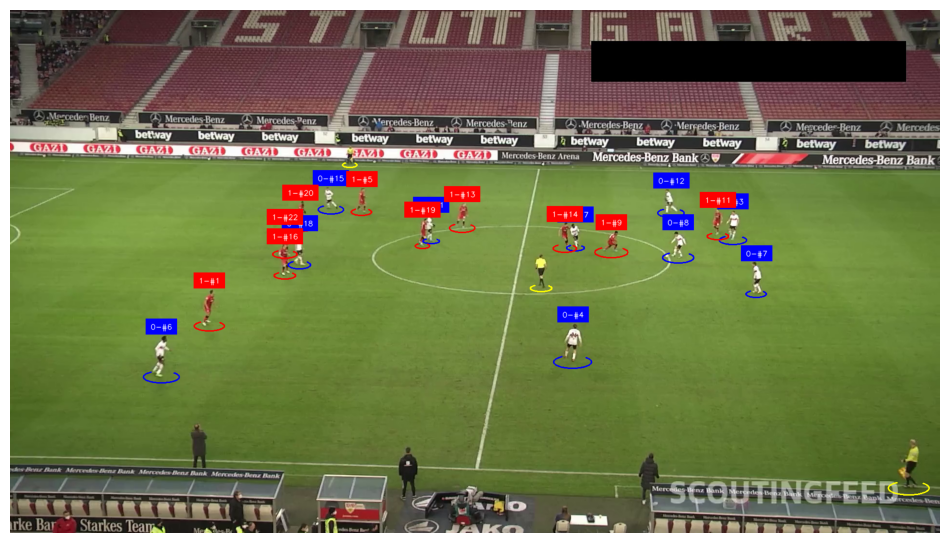

In [9]:
'''
Objective
To process a football video and:

1-Detect and track objects such as the ball, players, goalkeepers, and referees.
2-Classify players into teams.
3-Annotate video frames with positional and team information.
4-Output annotated frames for visualization.

'''

# Import necessary libraries and modules
# OpenCV and NumPy are used for image processing and mathematical operations.
# Supervision (sv) provides tools for object detection, tracking, and annotation.
# YOLO is the object detection model, and other modules handle team classification and goalkeeper resolution.
import cv2
import numpy as np
import supervision as sv
from ultralytics import YOLO
import TeamSplit  # Ensure this module handles team-related logic correctly
import pickle
from inference_sdk import InferenceHTTPClient
from goalkeepers import resolve_goalkeepers

# Define entity IDs for object classes
# These IDs correspond to specific objects detected by the model (e.g., ball, player, etc.).
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

# Define file paths for the YOLO model, video file, and team classifier
# The paths point to the detection model, input video, and saved classifier for team prediction.
player_model_path = "Parameters/Player.pt"
video_path = "Video/uc.mp4"
classifier_save_path = "Parameters/team_classifier2.pkl"

# Load the team classifier model
# The classifier is used to assign players to specific teams based on cropped player images.
with open(classifier_save_path, 'rb') as f:
    team_classifier = pickle.load(f)

# Define class names for detection
# These names correspond to the detected objects for annotation and debugging.
class_names = ['ball', 'goalkeeper', 'player', 'referee']

# Initialize the video frame generator
# This function extracts frames from the video for processing.
generator = sv.get_video_frames_generator(video_path)
frame = next(generator)

# Initialize the ByteTrack tracker
# The tracker helps in maintaining object identities across frames for better tracking.
tracker = sv.ByteTrack()
tracker.reset()

# Load the YOLO model for object detection
# This model is responsible for detecting players, referees, and the ball.
model = YOLO(player_model_path)

# Extract the first frame from the video for detection and annotation
# This is an initial setup step to test the detection pipeline.
frame_generator = sv.get_video_frames_generator(video_path)
PlayerFrame = next(frame_generator)

# Perform object detection on the current frame
# The YOLO model predicts bounding boxes and class IDs for detected objects.
result = model.predict(frame, device='cuda')[0]
detections = sv.Detections.from_ultralytics(result)

# Filter detected objects into different categories (ball, players, referees, etc.)
# This step prepares separate lists of detections for easier processing.
ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

# Apply non-maximum suppression to remove redundant detections
# This ensures only the most confident detections are kept.
all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

# Separate detections into specific categories
# This step organizes detections into goalkeepers, players, and referees.
goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

# Crop player images for team classification
# The cropped images are passed through the team classifier to assign team IDs.
cropss = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(cropss)

# Resolve goalkeeper team affiliations
# Assign team IDs to goalkeepers based on the team classification logic.
goalkeepers_detections.class_id = resolve_goalkeepers.resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

# Merge player and goalkeeper detections into one list
# This combines all players (including goalkeepers) for annotation.
all_detections = sv.Detections.merge([players_detections, goalkeepers_detections])

# Create a copy of the frame for adding annotations
# This frame will be updated with visual annotations for better understanding.
annotated_frame = frame.copy()

# Annotate Team 0 (Blue) players
# Blue ellipses are drawn around players from Team 0.
ellipse_annotator_team_0 = sv.EllipseAnnotator(color=sv.Color.BLUE)
annotated_frame = ellipse_annotator_team_0.annotate(scene=annotated_frame, detections=all_detections[all_detections.class_id == 0])

# Annotate Team 1 (Red) players
# Red ellipses are drawn around players from Team 1.
ellipse_annotator_team_1 = sv.EllipseAnnotator(color=sv.Color.RED)
annotated_frame = ellipse_annotator_team_1.annotate(scene=annotated_frame, detections=all_detections[all_detections.class_id == 1])

# Annotate referees (Yellow)
# Yellow ellipses are drawn around referees.
ellipse_annotator_referee = sv.EllipseAnnotator(color=sv.Color.YELLOW)
annotated_frame = ellipse_annotator_referee.annotate(scene=annotated_frame, detections=referees_detections)

# Annotate the ball (Triangle shape)
# The ball is annotated with a triangular marker for easy identification.
triangle_annotator = sv.TriangleAnnotator(base=30, height=20)
annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)

# Generate labels for Team 0 and Team 1 players
# Labels include the team ID and the tracker's unique object ID.
labels_team_0 = [f"0-#{tracker_id}" for tracker_id, team in zip(all_detections.tracker_id, all_detections.class_id) if team == 0]
labels_team_1 = [f"1-#{tracker_id}" for tracker_id, team in zip(all_detections.tracker_id, all_detections.class_id) if team == 1]

# Annotate Team 0 (Blue) with labels
# Labels are displayed on top of Team 0 players for better visualization.
label_annotator_team_0 = sv.LabelAnnotator(text_position=sv.Position.TOP_CENTER, color=sv.Color.BLUE)
annotated_frame = label_annotator_team_0.annotate(scene=annotated_frame, detections=all_detections[all_detections.class_id == 0], labels=labels_team_0)

# Annotate Team 1 (Red) with labels
# Labels are displayed on top of Team 1 players for better visualization.
label_annotator_team_1 = sv.LabelAnnotator(text_position=sv.Position.TOP_CENTER, color=sv.Color.RED)
annotated_frame = label_annotator_team_1.annotate(scene=annotated_frame, detections=all_detections[all_detections.class_id == 1], labels=labels_team_1)

# Plot the final annotated frame
# The final annotated frame is displayed using the Supervision library.
sv.plot_image(annotated_frame)


[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (7, 8), (10, 11), (11, 12), (12, 13), (14, 15), (15, 16), (16, 17), (18, 19), (19, 20), (20, 21), (23, 24), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (1, 14), (2, 10), (3, 7), (4, 8), (5, 13), (6, 17), (14, 25), (18, 26), (23, 27), (24, 28), (21, 29), (17, 30)]


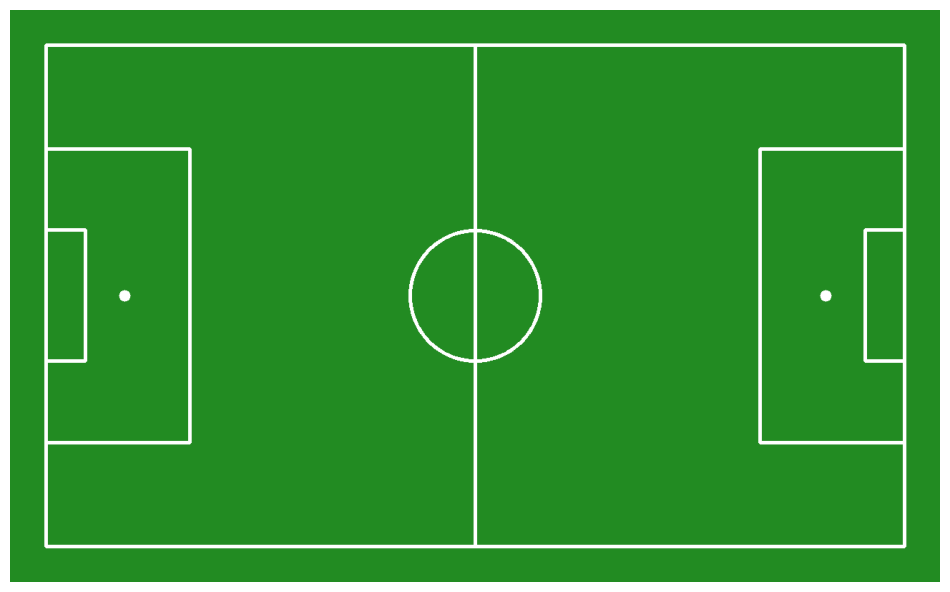

In [10]:
'''
Objective:
The objective of this code is to draw a soccer FootBall pitch layout on an image or canvas using a predefined configuration and visualize it.
The configuration defines the soccer FootBall pitch's dimensions and markings, which are used to create an accurate representation of the field.
'''
# Import the required modules
# - `draw_pitch` is used to draw the soccer FootBall pitch based on a given configuration.
# - `SoccerPitchConfiguration` provides the field's standard dimensions and markings.
# - `supervision` (sv) is used to handle visualization tasks, such as displaying the annotated frame.
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration
import supervision as sv

# Load the soccer FootBall pitch configuration
# The configuration contains standard field dimensions and edge data (e.g., goal areas, center circle, etc.).
CONFIG = SoccerPitchConfiguration()

# Print the configuration edges
# This provides details about the FootBall pitch structure, useful for debugging or customization.
print(CONFIG.edges)

# Draw the soccer FootBall pitch using the loaded configuration
# The function generates an annotated image representing the soccer FootBall pitch layout.
annotated_frame = draw_pitch(CONFIG)

# Visualize the annotated frame
# Display the generated soccer FootBall pitch using Supervision's plot_image function.
sv.plot_image(annotated_frame)


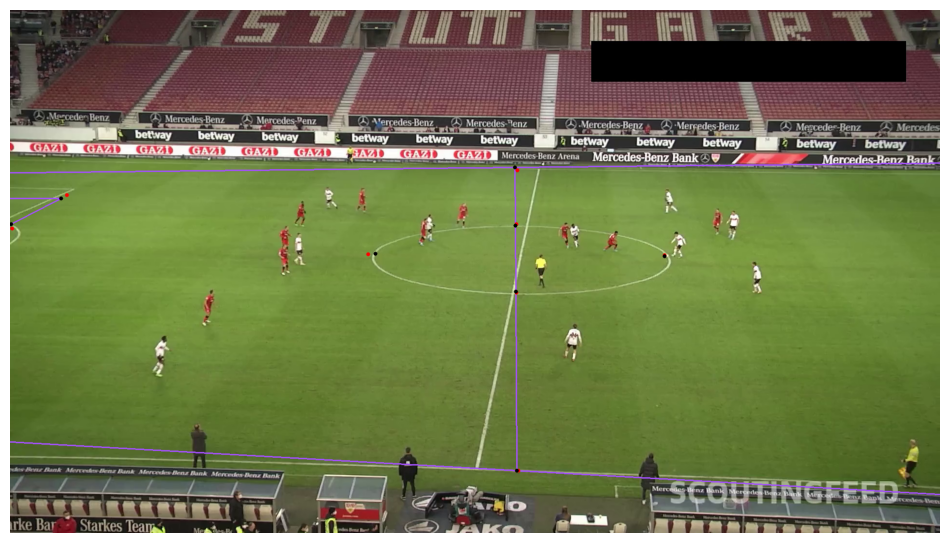

In [11]:
'''
Objective:
The purpose of this code is to detect key points of a soccer field from a video frame, filter them based on confidence scores,
and align them with the predefined FootBall pitch layout using a transformation matrix. The resulting annotations highlight the edges, source key points,
and detection key points on the soccer field for visualization.

'''
# Import necessary libraries and modules
# - InferenceHTTPClient: For accessing the keypoint detection model API.
# - Supervision (sv): For visualization and annotation tasks.
# - Soccer modules: For FootBall pitch configuration and layout drawing.
# - PyTorch, NumPy, and YOLO: For processing and computations.
from inference_sdk import InferenceHTTPClient
import supervision as sv
from sports.common.view import ViewTransformer
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration
import torch
import numpy as np
from ultralytics import YOLO
from goalkeepers import resolve_goalkeepers

# Define the path to the input video file
video_path = "Video/uc.mp4"

# Restore the source FootBall pitch configuration
# The configuration provides the standard soccer FootBall pitch layout, including vertices and edges.
CONFIG = SoccerPitchConfiguration()

# Initialize the keypoint detection model via an HTTP client
# This connects to the model API for detecting key points of the soccer field.
KeyPont_model = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="AO3urwNsObTMAmWoKuun"
)

# Generate the first video frame for analysis
genrator = sv.get_video_frames_generator(video_path)
Keyframe = next(genrator)

# Predict keypoints for the soccer field using the model
# The result contains keypoints and confidence scores for each detected feature.
result = KeyPont_model.infer(Keyframe, model_id="football-field-detection-f07vi/15")
key_point = sv.KeyPoints.from_inference(result)

# Filter the keypoints based on confidence scores (threshold = 0.5)
# Extract only the high-confidence keypoints for further processing.
filter = key_point.confidence[0] > 0.5
frame_KeyPoint_filter = key_point.xy[0][filter]  # Shape after filtering: (N, 2)

# Convert filtered keypoints into a 3D array for annotation
key_point_3d = sv.KeyPoints(xy=frame_KeyPoint_filter[np.newaxis, ...])

# Extract the target keypoints from the FootBall pitch configuration
# The vertices represent the predefined FootBall pitch points.
pich_KeyPoint = np.array(CONFIG.vertices)
pich_KeyPoint_filter = pich_KeyPoint[filter]

# Initialize a view transformer for alignment
# Align the detected keypoints with the FootBall pitch layout using the filtered points.
transformer = ViewTransformer(source=pich_KeyPoint_filter, target=frame_KeyPoint_filter)
pitch_all_point = transformer.transform_points(pich_KeyPoint)
pitch_all_point_3d = sv.KeyPoints(xy=pitch_all_point[np.newaxis, ...])

# Create a copy of the original frame for annotation
annotated_frame = Keyframe.copy()

# Annotate the FootBall pitch edges based on the configuration
edge_annotator = sv.EdgeAnnotator(edges=CONFIG.edges)
annotated_frame = edge_annotator.annotate(scene=annotated_frame, key_points=pitch_all_point_3d)

# Annotate the detection keypoints (in red)
vertex_annotator = sv.VertexAnnotator(color=sv.Color.RED)
annotated_frame = vertex_annotator.annotate(scene=annotated_frame, key_points=key_point_3d)

# Annotate the source keypoints (in black)
vertex_annotator = sv.VertexAnnotator(color=sv.Color.BLACK)
annotated_frame = vertex_annotator.annotate(scene=annotated_frame, key_points=pitch_all_point_3d)

# Visualize the annotated frame
# Display the final annotated soccer field with edges and keypoints.
sv.plot_image(annotated_frame)



0: 384x640 20 players, 3 referees, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 16.6ms postprocess per image at shape (1, 3, 384, 640)


Embedding extraction: 1it [00:00,  1.50it/s]


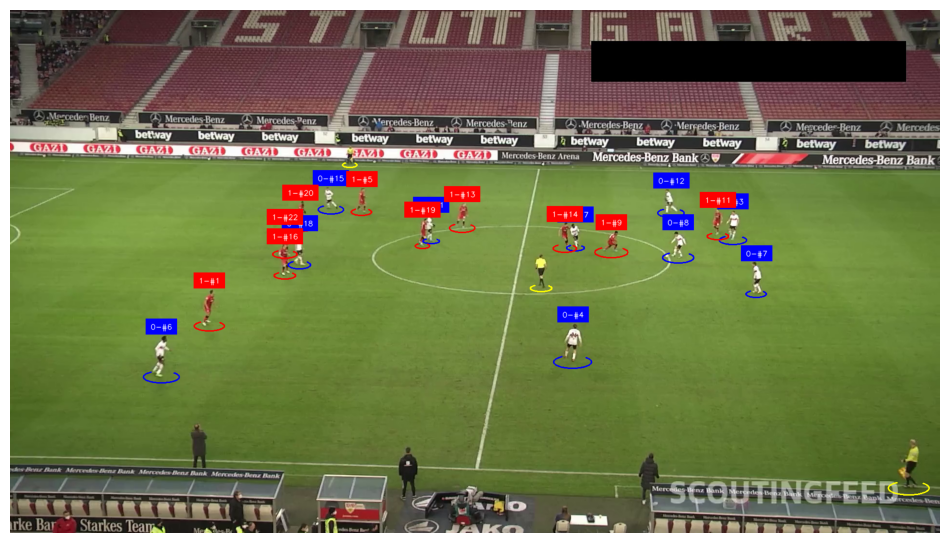

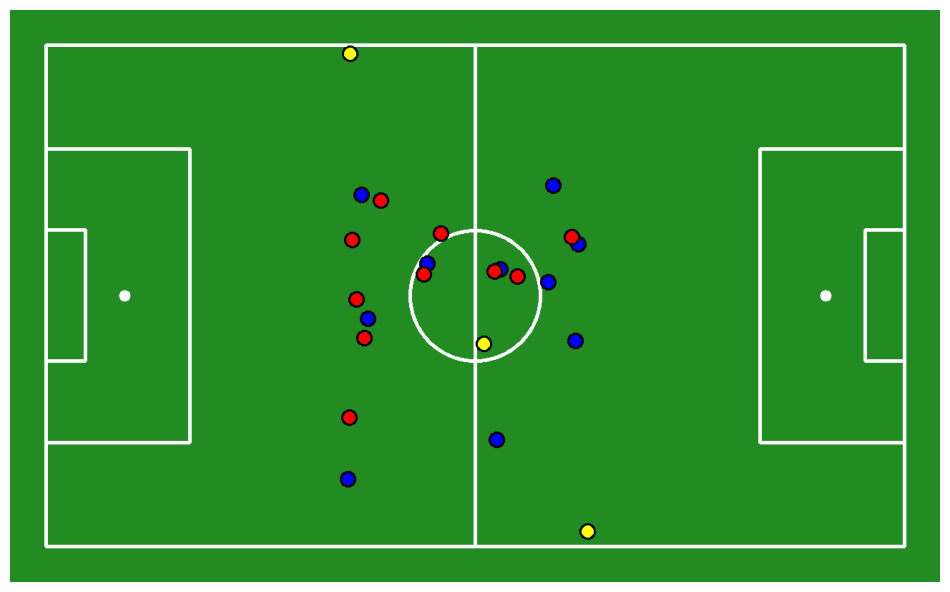

In [12]:
'''
Objective:
This code integrates multiple functionalities to analyze a soccer video. It detects and tracks players, referees, and the ball, classifies players into teams, 
aligns detected objects with the soccer FootBall pitch layout, and visualizes the final result. 
The code also annotates the field, players, and ball positions, creating a comprehensive visual representation of a soccer match.

'''
# Import required libraries and modules
import cv2
import numpy as np
import supervision as sv
from ultralytics import YOLO
import TeamSplit  # Custom module for team splitting logic (ensure it's defined in your project)
import pickle
from inference_sdk import InferenceHTTPClient
from sports.common.view import ViewTransformer
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch, draw_pitch_voronoi_diagram, SoccerPitchConfiguration
from goalkeepers import resolve_goalkeepers  # For resolving goalkeepers' team associations

# --- Variables ---
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3
player_model_path = "Parameters/Player.pt"  # Path to the player detection model
video_path = "Video/uc.mp4"  # Path to the input video
classifier_save_path = "Parameters/team_classifier2.pkl"  # Path to the saved team classifier model

# --- Load Team Classifier Model ---
with open(classifier_save_path, 'rb') as f:
    team_classifier = pickle.load(f)

# --- Video Frame Generator ---
# Extract the first frame from the input video
generator = sv.get_video_frames_generator(video_path)
frame = next(generator)

# --- Initialize Tracker ---
# ByteTrack is used for tracking players, referees, and the ball across frames
tracker = sv.ByteTrack()
tracker.reset()

# --- Load Player Detection Model ---
model = YOLO(player_model_path)
result = model.predict(frame, device='cuda')[0]  # Perform inference on the frame
detections = sv.Detections.from_ultralytics(result)

# --- Filter Detections ---
# Separate detections for the ball, referees, and players
ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)  # Expand ball detection bounding boxes

# Filter other detections and apply non-maximum suppression (NMS)
all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

# Separate players, referees, and goalkeepers
goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

# Classify players into teams using the loaded classifier
cropss = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(cropss)

# Assign goalkeepers to their respective teams
goalkeepers_detections.class_id = resolve_goalkeepers.resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)
all_detections.class_id = all_detections.class_id.astype(int)
all_detections = sv.Detections.merge([players_detections, goalkeepers_detections])

# --- Annotate Frame ---
# Create a copy of the frame for annotation
annotated_frame = frame.copy()

# Annotate Team 0 (Blue) players
ellipse_annotator_team_0 = sv.EllipseAnnotator(color=sv.Color.BLUE)
annotated_frame = ellipse_annotator_team_0.annotate(scene=annotated_frame, detections=all_detections[all_detections.class_id == 0])

# Annotate Team 1 (Red) players
ellipse_annotator_team_1 = sv.EllipseAnnotator(color=sv.Color.RED)
annotated_frame = ellipse_annotator_team_1.annotate(scene=annotated_frame, detections=all_detections[all_detections.class_id == 1])

# Annotate referees (Yellow)
ellipse_annotator_referee = sv.EllipseAnnotator(color=sv.Color.YELLOW)
annotated_frame = ellipse_annotator_referee.annotate(scene=annotated_frame, detections=referees_detections)

# Annotate the ball (Triangle shape)
triangle_annotator = sv.TriangleAnnotator(base=30, height=20)
annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)

# Generate labels for players based on teams
labels_team_0 = [f"0-#{tracker_id}" for tracker_id, team in zip(all_detections.tracker_id, all_detections.class_id) if team == 0]
labels_team_1 = [f"1-#{tracker_id}" for tracker_id, team in zip(all_detections.tracker_id, all_detections.class_id) if team == 1]

# Annotate labels for Team 0 (Blue) players
label_annotator_team_0 = sv.LabelAnnotator(text_position=sv.Position.TOP_CENTER, color=sv.Color.BLUE)
annotated_frame = label_annotator_team_0.annotate(scene=annotated_frame, detections=all_detections[all_detections.class_id == 0], labels=labels_team_0)

# Annotate labels for Team 1 (Red) players
label_annotator_team_1 = sv.LabelAnnotator(text_position=sv.Position.TOP_CENTER, color=sv.Color.RED)
annotated_frame = label_annotator_team_1.annotate(scene=annotated_frame, detections=all_detections[all_detections.class_id == 1], labels=labels_team_1)

# Display the annotated frame
sv.plot_image(annotated_frame)

# --- Keypoint Model ---
# Initialize soccer FootBall pitch configuration and keypoint detection model
CONFIG = SoccerPitchConfiguration()
KeyPont_model = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="AO3urwNsObTMAmWoKuun"
)

# Perform inference for keypoint detection
result = KeyPont_model.infer(annotated_frame, model_id="football-field-detection-f07vi/15")
key_points = sv.KeyPoints.from_inference(result)

# Filter detected keypoints based on confidence
filter = key_points.confidence[0] > 0.5
source_KeyPoint_filter = key_points.xy[0][filter]  # Source keypoints (filtered)
target_KeyPoint_filter = np.array(CONFIG.vertices)[filter]  # Target keypoints

# Apply transformation to align detected points with the FootBall pitch layout
transformer = ViewTransformer(source_KeyPoint_filter, target_KeyPoint_filter)

# Transform coordinates of ball, players, and referees
ball = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
ball = transformer.transform_points(points=ball)

player = all_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
player = transformer.transform_points(player)

referees = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
referees = transformer.transform_points(referees)

# Draw FootBall pitch and annotate objects
annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_points_on_pitch(CONFIG, xy=ball, face_color=sv.Color.WHITE, edge_color=sv.Color.BLACK, radius=10, pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(CONFIG, xy=player[all_detections.class_id == 0], pitch=annotated_frame, face_color=sv.Color.BLUE)
annotated_frame = draw_points_on_pitch(CONFIG, xy=player[all_detections.class_id == 1], pitch=annotated_frame, face_color=sv.Color.RED)
annotated_frame = draw_points_on_pitch(CONFIG, xy=referees, pitch=annotated_frame, face_color=sv.Color.YELLOW)

# Display the final annotated FootBall pitch
sv.plot_image(annotated_frame)
